In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from nbodykit.lab import *
import bigfile

### the redshfit distribution of rsd mock, true vs rsd

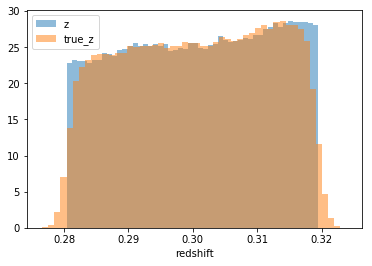

In [5]:
topdir = '/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks2/angcorr_data/'
dat1=fits.getdata(topdir+'rsd_angcorr1.fits')
plt.hist(dat1['z'],alpha=0.5,bins=50,label='z',density=True)
plt.hist(dat1['true_z'],alpha=0.5,bins=50,label='true_z',density=True)
plt.xlabel('redshift')
plt.legend()

### valiating ra,dec does not get changed much with rsd

Text(0,0.5,'$\\Delta ra$')

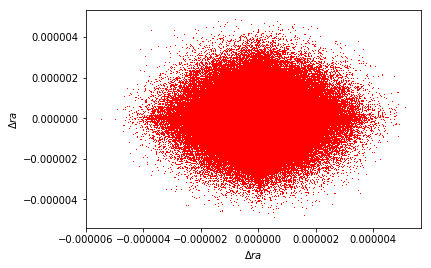

In [8]:
plt.plot(dat1['ra']-dat1['true_ra'],dat1['dec']-dat1['true_dec'],'r,')
plt.xlabel(r'$\Delta ra$')
plt.ylabel(r'$\Delta ra$')

compare power spectrum generated by camb and nbodykit

Text(0.5,1,'matter power spectrum')

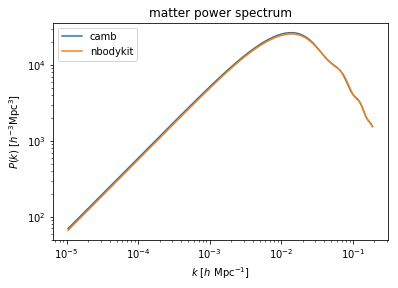

In [30]:
h=0.7
omega_b=0.044
omega_m=0.25
ns=0.95
sigma8=0.8
redshift=0.3
import numpy as np
import matplotlib.pyplot as plt
cosmo = cosmology.cosmology.Cosmology(h=h,Omega0_b=omega_b,Omega0_cdm=omega_m-omega_b,n_s=ns)
cosmo2=cosmo.match(sigma8=sigma8)
Plin = cosmology.LinearPower(cosmo2, redshift, transfer='EisensteinHu')

pk2=np.loadtxt('/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/nbody_kit/notebook/external_data/pk.txt').transpose()
plt.plot(pk2[0][:222],pk2[1][:222],label='camb')

k=pk2[0][:222]
mx=Plin(k).max()

plt.plot(k,Plin(k),label='nbodykit')
plt.legend()
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title('matter power spectrum')

Text(0.5,1,'P(k) ratio')

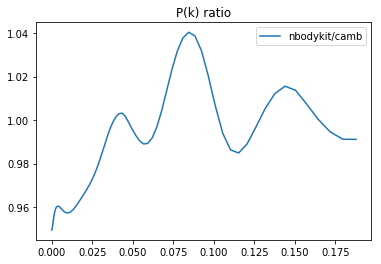

In [12]:
plt.plot(k,Plin(k)/pk2[1][:222],label='nbodykit/camb')
plt.legend()
plt.title('P(k) ratio')

In [41]:
cat = BigFileCatalog('/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks2/mocks/mock0.bigfile', header='Header')

#f = bigfile.File('/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks2/mocks/mock0.bigfile')
#cat = bigfile.Dataset(f,['Position','VelocityOffset'])
#this is a toy line of sight, it is not what is done when actually computing rsd
line_of_sight = [0,0,1]
cat['RSDPosition'] = cat['Position'] + cat['VelocityOffset'] * line_of_sight

mesh = cat.to_mesh(window='tsc', Nmesh=512, compensated=True, position='RSDPosition')
mesh2 = cat.to_mesh(window='tsc', Nmesh=512, compensated=True, position='Position')
# compute the power, specifying desired linear k-binning
r = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.001)
r2 = FFTPower(mesh2, mode='1d', dk=0.005, kmin=0.001)
Pk = r.power
Pk2 = r2.power
print(Pk)

<BinnedStatistic: dims: (k: 214), variables: ('k', 'power', 'modes')>


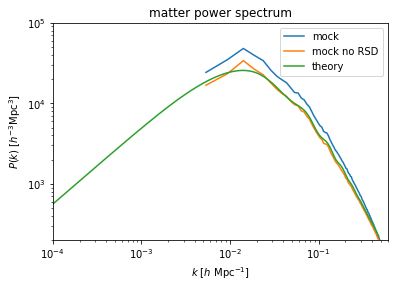

In [49]:
# print the shot noise subtracted P(k)
plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'],label='mock')
plt.loglog(Pk2['k'], Pk2['power'].real - Pk2.attrs['shotnoise'],label='mock no RSD')

k=pk2[0][:243]
plt.plot(k,Plin(k),label='theory')


# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.0001, 0.6)
plt.ylim(2*10**2,10**5)

plt.title('matter power spectrum')
plt.legend()

### 3d correlation function

compute the power, specifying desired linear k-binning.
this thing takes too long to run.
last time I tried, SimulationBox2PCF returns the same result as treecorr, but FFTCorr has a different amplitude
```python
r = FFTCorr(mesh, mode='1d', dr=1) #rsd
r2 = FFTCorr(mesh2, mode='1d', dr=1) #no rsd
r.run()

s1 = SimulationBox2PCF('1d',mesh,edges=np.arange(1,100,1))
s1.run()

plt.plot(s1.corr['r'][1:95],1.3*s1.corr['r'][1:95]*s1.corr['r'][1:95]*s1.corr['corr'][1:95],label='SimulationBox2PCF')
plt.plot(r.corr['r'][1:100],r.corr['r'][1:100]*r.corr['r'][1:100]*r.corr['corr'][1:100],label='FFTCorr')
```

In [64]:
import sys
sys.path.append('/global/cscratch1/sd/huikong/wtheta_cal/software/')
def HankelTransform_corr(plin,bias=1):
    kmax = 4
    kmin = 10**(-4)
    N=200
    k_array = np.exp(np.array([ np.log(kmin)+i*(np.log(kmax)-np.log(kmin))/N for i in np.arange(0,200)]))
    pk = plin(k_array)
    q=1.5
    mu=0.5
    from BAOfit import fftlog_JB
    r,xi=fftlog_JB.HankelTransform(k_array,pk,q,mu,output_r=np.arange(0,200),output_r_power=-3)
    y=xi/np.pi**2*np.sqrt(np.pi/2)/2*bias**2
    return r,y

r0,y0=HankelTransform_corr(Plin)

In [74]:
topdir = '/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks2/3dcorr_result/'
import glob
fns = glob.glob(topdir+'3dcorr_*')
length = len(fns)
print(length)
t3d_corr=None

for fn in fns:
    t3d_corr_i = np.loadtxt(fn).transpose()
    #print(fn)
    if t3d_corr is None:
        t3d_corr = t3d_corr_i
    else:
        #print(fn)
        t3d_corr+=t3d_corr_i
        
t3d_corr = t3d_corr/length


100


In [68]:
import scipy.integrate as integrate
#Ingegrate(Pk*k^2*sin(kr)/kr)
result=[]
for i in range(1,200,2):
    r=i
    result_i = integrate.quad(lambda k: k**2*Plin(k)*np.sin(k*r)/(k*r)/np.pi**2, 0, 4)
    result.append(result_i[0])

/global/homes/h/huikong/.conda/envs/cfastpm/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


mock is using 40 evenly spaced bins


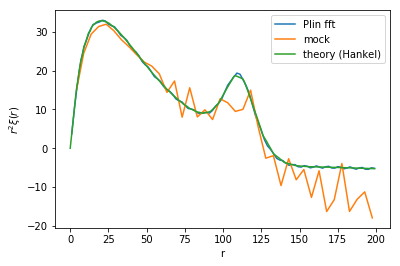

In [76]:
xx=np.arange(1,200,2)
plt.plot(xx,0.5*xx*xx*np.array(result).transpose(),label='Plin fft')
plt.plot(t3d_corr[0],t3d_corr[0]*t3d_corr[0]*t3d_corr[1],label='mock')
plt.plot(r0,r0*r0*y0,label='theory (Hankel)')
plt.legend()
plt.ylabel(r'$r^2\xi(r)$')
plt.xlabel('r')
print('mock is using 40 evenly spaced bins')

angular correltion function between rsd and non-rsd

In [23]:
topdir = '/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks2/angcorr_result/'
#non rsd
import glob
fns = glob.glob(topdir+'angcorr_*')
length = len(fns)
print(length)
ang_corr=None
for fn in fns:
    ang_corr_i = np.loadtxt(fn).transpose()
    #print(fn)
    if ang_corr is None:
        ang_corr = ang_corr_i
    else:
        #print(fn)
        ang_corr+=ang_corr_i

ang_corr = ang_corr/length
#rsd
fns = glob.glob(topdir+'rsd_angcorr_*')
length = len(fns)
print(length)
rsd_ang_corr=None
for fn in fns:
    ang_corr_i = np.loadtxt(fn).transpose()
    #print(fn)
    if rsd_ang_corr is None:
        rsd_ang_corr = ang_corr_i
    else:
        #print(fn)
        rsd_ang_corr+=ang_corr_i

rsd_ang_corr = rsd_ang_corr/length

100
100


In [24]:
ang_corr_var=None
ang_corr_var2=None
length_ang = len(fns)
for fn in fns:
    ang_corr_i = np.loadtxt(fn).transpose()
    #print(fn)
    if ang_corr_var is None:
        ang_corr_var = (ang_corr_i[1]-rsd_ang_corr[1])**2
        ang_corr_var2 = ang_corr_i[2]
    else:
        ang_corr_var += (ang_corr_i[1]-rsd_ang_corr[1])**2
        ang_corr_var2 += ang_corr_i[2]

x=ang_corr[0]
ang_corr_var = np.sqrt(ang_corr_var/(length_ang-1))
ang_corr_var2 = np.sqrt(ang_corr_var2/length_ang)

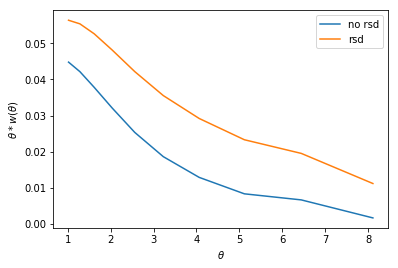

In [16]:
plt.plot(ang_corr[0],ang_corr[0]*ang_corr[1],label='no rsd')
plt.plot(rsd_ang_corr[0],rsd_ang_corr[0]*rsd_ang_corr[1],label='rsd')
plt.ylabel(r'$\theta*w(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend()

CosmoCov gaus result

In [72]:
topdir='/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/theory_corr/CosmoCov/covs/output/out_cov_mock_gaus/'
fn = topdir+'test_mock2_llll_cov_Ntheta10_Ntomo0_1'
cov = np.loadtxt(fn)
gaus_angle=[]
gaus_value=[]
for i in range(len(cov)):
    if cov[i][0]==cov[i][1]:
        gaus_angle.append(cov[i][2])
        gaus_value.append(cov[i][8])

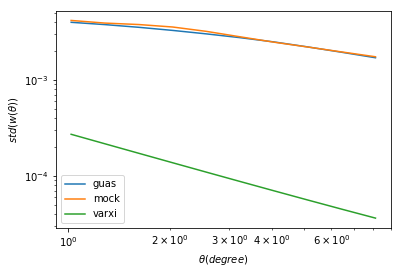

In [83]:
plt.plot(np.array(gaus_angle)*180/np.pi,np.sqrt(np.array(gaus_value)),label='guas')
plt.plot(rsd_ang_corr[0],ang_corr_var,label='mock') 
plt.plot(rsd_ang_corr[0],ang_corr_var2,label='varxi')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel(r'$\theta (degree)$')
plt.ylabel(r'$std(w(\theta))$')
plt.legend()

### angular correlation function from theory and mock

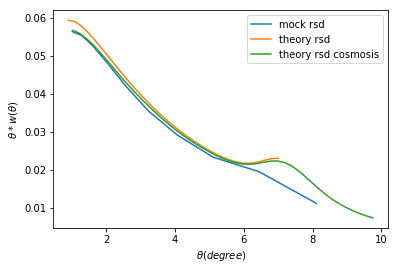

In [86]:
fn = '/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/nbody_kit/notebook/external_data/angcorr_theory.txt' 
#cosmosis
topdir = '/global/cscratch1/sd/huikong/fnl_analysis/theory_desi_MOCK/lss_autocorrelation/'
theta = np.loadtxt(topdir+'theta_deg.txt')
wtheta = np.loadtxt(topdir+'bin_1_1.txt')
import numpy as np
dat = np.loadtxt(fn).transpose()
plt.plot(rsd_ang_corr[0],rsd_ang_corr[0]*rsd_ang_corr[1],label='mock rsd')
plt.plot(dat[0][5:],dat[0][5:]*dat[1][5:],label='theory rsd')
plt.plot(theta[5:],theta[5:]*wtheta[5:],label='theory rsd cosmosis')
plt.ylabel(r'$\theta*w(\theta)$') 
plt.xlabel(r'$\theta (degree)$')
plt.legend()